## Loading the cifar 10 dataset

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from IPython import display
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import cifar10

cifar10.maybe_download_and_extract()
images_train, cls_train, labels_train = cifar10.load_training_data()


Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


## Checking the dimension of the dataset
<html> <h3>Here I am using only 50000 examples to train the GAN
Also loading the labels, to plot the images for checking if the correct images are loaded</h3></html>

In [2]:
print(images_train.shape)
class_names = cifar10.load_class_names()
print(class_names)

(50000, 32, 32, 3)
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Function used to plot the images for checking

In [3]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

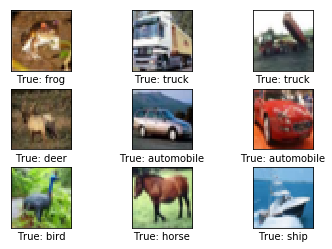

In [4]:
# Get the first images from the test-set.
images = images_train[0:9]

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

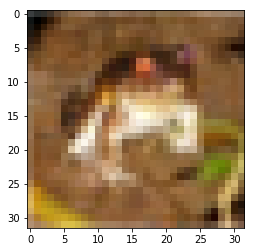

In [5]:
plt.imshow(images_train[0])

## Making a directory containing only 30 images. Will be using this directory for calculating the inception score.

In [6]:
import imageio
folder="data_30_images/"

for i in range(30):
    string=folder+"image_"+str(i)+'.png'
    imageio.imwrite(string, images_train[i])

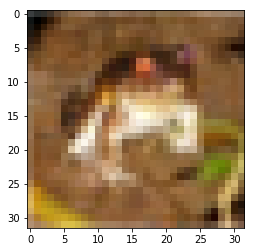

In [7]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('data_30_images/*.png'): 
    im=Image.open(filename)
    plt.imshow(np.asarray(im))


## This is the code for printing the generated images generated by the generator

In [8]:
def montage(images):    
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    print(img_h,img_w)
    print(images.shape)
    n_plots_rows = 2
    n_plots_cols=6
    if len(images.shape) == 4 and images.shape[3] == 3:
        m = np.ones(
            (images.shape[1] * n_plots_rows + n_plots_rows + 1,
             images.shape[2] * n_plots_cols + n_plots_cols + 1, 3))
    elif len(images.shape) == 4 and images.shape[3] == 1:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 1))
    elif len(images.shape) == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1))
    else:
        raise ValueError('Could not parse image shape of {}'.format(
            images.shape))
    for i in range(n_plots_rows):
        for j in range(n_plots_cols):
            this_filter = i *n_plots_cols  + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m


<html><h1> The procedure</h1><p> The data is divided into batched of 100 examples, the noise also has a dimension of 100 X 100 </p><p><h2> Discriminator </h2> The discriminator takes the input , reshapes it to a  32 X 32 X 3 array and applies layers of convolution and dropout, similarly the generator also performs the reverse operation.</p></html> 

In [9]:
tf.reset_default_graph()
batch_size = 100
n_noise = 100

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3], name='X')
noise = tf.placeholder(dtype=tf.float32, shape=[None, n_noise])

keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')

def lrelu(x):
    return tf.maximum(x, tf.multiply(x, 0.2))

def binary_cross_entropy(x, z):
    eps = 1e-12
    return (-(x * tf.log(z + eps) + (1. - x) * tf.log(1. - z + eps)))

def discriminator(img_in, reuse=None, keep_prob=keep_prob):
    activation = lrelu
    with tf.variable_scope("discriminator", reuse=reuse):
        x = tf.reshape(img_in, shape=[-1, 32, 32, 3])
        print("X inside discriminator 1. ",x.get_shape,"\n")
        x = tf.layers.conv2d(x, kernel_size=5, filters=256, strides=2, padding='same', activation=activation)
        print("X inside discriminator 2. ",x.get_shape,"\n")
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=128, strides=1, padding='same', activation=activation)
        print("X inside discriminator 3. ",x.get_shape,"\n")
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        print("X inside discriminator 4. ",x.get_shape,"\n")
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=128, activation=activation)
        x = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)
        print("LAST SHAPE of x inside the discriminator",x.get_shape,"\n")
        return x
    
def generator(z, keep_prob=keep_prob, is_training=is_training):
    activation = lrelu
    momentum = 0.9
    with tf.variable_scope("generator", reuse=None):
        x = z
        
        d1 = 4#3
        d2 = 3
        
        x = tf.layers.dense(x, units=d1 * d1 * d2, activation=activation)
        x = tf.layers.dropout(x, keep_prob)      
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)  
        
        x = tf.reshape(x, shape=[-1, d1, d1, d2])
        x = tf.image.resize_images(x, size=[8, 8])
        print("X inside generator 1.",x.get_shape,"\n")
        
        
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=256, strides=2, padding='same', activation=activation)
        print("X inside generator 2.",x.get_shape,"\n")
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=128, strides=2, padding='same', activation=activation)
        print("X inside generator 3.",x.get_shape,"\n")
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        print("X inside generator 4.",x.get_shape,"\n")
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=3, strides=1, padding='same', activation=tf.nn.sigmoid)
        print("X inside generator 5.",x.get_shape,"\n")
        print("LAST SHAPE of x inside the generator",x.get_shape,"\n")
        return x

In [10]:
global_step = tf.Variable(initial_value=0,name='global_step', trainable=False)

In [11]:
g = generator(noise, keep_prob, is_training)
d_real = discriminator(X_in)
d_fake = discriminator(g, reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]


d_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_d)
g_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_g)

loss_d_real = binary_cross_entropy(tf.ones_like(d_real), d_real)
loss_d_fake = binary_cross_entropy(tf.zeros_like(d_fake), d_fake)
loss_g = tf.reduce_mean(binary_cross_entropy(tf.ones_like(d_fake), d_fake))

loss_d = tf.reduce_mean(0.5 * (loss_d_real + loss_d_fake))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(loss_d + d_reg, var_list=vars_d,global_step=global_step)
    optimizer_g = tf.train.RMSPropOptimizer(learning_rate=0.0002).minimize(loss_g + g_reg, var_list=vars_g,global_step=global_step)


X inside generator 1. <bound method Tensor.get_shape of <tf.Tensor 'generator/resize_images/ResizeBilinear:0' shape=(?, 8, 8, 3) dtype=float32>> 

X inside generator 2. <bound method Tensor.get_shape of <tf.Tensor 'generator/conv2d_transpose/Maximum:0' shape=(?, 16, 16, 256) dtype=float32>> 

X inside generator 3. <bound method Tensor.get_shape of <tf.Tensor 'generator/conv2d_transpose_1/Maximum:0' shape=(?, 32, 32, 128) dtype=float32>> 

X inside generator 4. <bound method Tensor.get_shape of <tf.Tensor 'generator/conv2d_transpose_2/Maximum:0' shape=(?, 32, 32, 64) dtype=float32>> 

X inside generator 5. <bound method Tensor.get_shape of <tf.Tensor 'generator/conv2d_transpose_3/Sigmoid:0' shape=(?, 32, 32, 3) dtype=float32>> 

LAST SHAPE of x inside the generator <bound method Tensor.get_shape of <tf.Tensor 'generator/conv2d_transpose_3/Sigmoid:0' shape=(?, 32, 32, 3) dtype=float32>> 

X inside discriminator 1.  <bound method Tensor.get_shape of <tf.Tensor 'discriminator/Reshape:0' sh

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [13]:
import os
save_dir = 'checkpoints_augment/cifar10-gan'

#create the directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [14]:
save_path = os.path.join(save_dir, 'cifar10_cnn_augment')

In [15]:
saver = tf.train.Saver()

In [16]:
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(sess, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.",sys.exc_info()[0])
    sess.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from checkpoints_augment/cifar10-gan/cifar10_cnn_augment-94522


INFO:tensorflow:Restoring parameters from checkpoints_augment/cifar10-gan/cifar10_cnn_augment-94522


Restored checkpoint from: checkpoints_augment/cifar10-gan/cifar10_cnn_augment-94522


## This function saves 10 of the generated images after every epoch

In [17]:
import matplotlib
def save_generated_images(gen_imgs,iteration):
    for i in range(10):
        directory="Generator_Images/Image_Epoch_Generated"+"_"+str(iteration)+"/"
        if not os.path.exists(directory):
            os.makedirs(directory)
        string=directory+"/"+"generated_images"+"_"+str(i)+".png"
        matplotlib.image.imsave(string, gen_imgs[i])
              

i_global =  [96324, None] ; 40 0.656577 0.896004
not training discriminator
32 32
(100, 32, 32, 3)


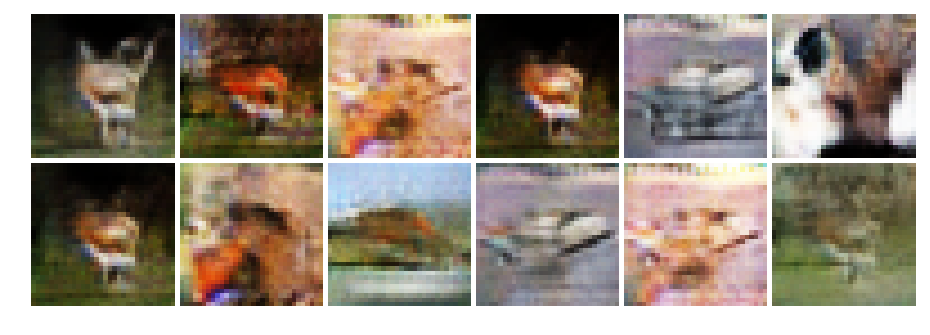

Stopped


In [80]:

try:
    current_index = 0
    epoch = 0
    n_batch = 0
    num_batches = 500

    for i in range(160000):
        train_d = True
        train_g = True
        keep_prob_train = 0.6 # 0.5
        n_batch+=1
        #batch_size = 64, n_noise = 64
        n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)   
        X_batch=images_train[current_index:current_index+batch_size]
        if(current_index==49900):
            current_index=0
        else:
            current_index=current_index+batch_size

        d_real_ls, d_fake_ls, g_ls, d_ls = sess.run([loss_d_real, loss_d_fake, loss_g, loss_d], feed_dict={X_in: X_batch, noise: n, keep_prob: keep_prob_train, is_training:True})

        d_fake_ls_init = d_fake_ls

        d_real_ls = np.mean(d_real_ls)
        d_fake_ls = np.mean(d_fake_ls)
        g_ls = g_ls
        d_ls = d_ls

        if g_ls * 1.35 < d_ls:
            train_g = False
            pass
        if d_ls * 1.35 < g_ls:
            train_d = False
            pass

        if train_d:
            i_global = sess.run([global_step,optimizer_d], feed_dict={noise: n, X_in: X_batch, keep_prob: keep_prob_train, is_training:True})


        if train_g:
            i_global = sess.run([global_step,optimizer_g], feed_dict={noise: n, keep_prob: keep_prob_train, is_training:True})


        if i%500==0:
            epoch+=1
            n_batch = 0
            saver.save(sess,save_path = save_path,global_step=global_step)

        if not i % 10:
            display.clear_output(True)
            print ("i_global = ",i_global,";",i, d_ls, g_ls)
            if not train_g:
                print("not training generator")
            if not train_d:
                print("not training discriminator")
            gen_imgs = sess.run(g, feed_dict = {noise: n, keep_prob: 1.0, is_training:False})
            imgs = [img[:,:,:] for img in gen_imgs]
    #         print("shape of image: ",gen_imgs.shape,"imgs shape: ",len(imgs))

            fig = plt.figure(figsize=(16, 16))
            m = montage(imgs)
            #m = imgs[0]
            plt.axis('off')
            plt.imshow(m, cmap='gray')
            string=str(i_global[0])+"_img.png"
            if not i%500:
                save_generated_images(gen_imgs,i_global[0])
                plt.savefig("generated_image/"+string)
            plt.show()
            plt.close()
except KeyboardInterrupt:
    print("Stopped by user")

## Inception Score Calculation
<html><p>We first need to load the generated images from the folder and then apply some preprocessing on it before calculating the inception score</p></html>

In [64]:
list_generated_images=[]
for filename in glob.glob('data_30_images/*.png'): 
    im=Image.open(filename)
    list_generated_images.append(np.asarray(im))

array_generated_images=np.asarray(list_generated_images,dtype="float32")
array_generated_images.shape


(60, 32, 32, 3)

In [74]:
transposed_images=[]
for i in range(array_generated_images.shape[0]):
    transposed_images.append(np.transpose(array_generated_images[i], (2, 1, 0)))
    

In [75]:
final_images=np.asarray(transposed_images)
final_images.shape

(60, 3, 32, 32)

In [76]:
import math

from chainer import Chain
from chainer import functions as F
from chainer import links as L
from chainer import Variable


def inception_score_new(model, ims, batch_size=100, splits=10):
    """Compute the inception score for given images.

    Default batch_size is 100 and split size is 10. Please refer to the
    official implementation. It is recommended to to use at least 50000
    images to obtain a reliable score.

    Reference:
    https://github.com/openai/improved-gan/blob/master/inception_score/model.py

    """
    print("Calculating Inception score")
    n, c, h, w = ims.shape
    n_batches = int(math.ceil(float(n) / float(batch_size)))

    xp = model.xp

    print('Batch size:', batch_size)
    print('Total number of images:', n)
    print("Total channels: ",c,"width: ",w,"height: ",h)

    # Compute the softmax predicitions for for all images, split into batches
    # in order to fit in memory

    ys = xp.empty((n, 1008), dtype=xp.float32)  # Softmax container

    for i in range(n_batches):

        print('Running batch', i + 1, '/', n_batches, '...')

        batch_start = (i * batch_size)
        batch_end = min((i + 1) * batch_size, n)

        ims_batch = ims[batch_start:batch_end]
        ims_batch = xp.asarray(ims_batch)  # To GPU if using CuPy
        ims_batch = Variable(ims_batch)

        # Resize image to the shape expected by the inception module
        if (w, h) != (299, 299):
            ims_batch = F.resize_images(ims_batch, (299, 299))  # bilinear

        # Feed images to the inception module to get the softmax predictions
        y = model(ims_batch)
        ys[batch_start:batch_end] = y.data

    # Compute the inception score based on the softmax predictions of the
    # inception module.
    scores = xp.empty((splits), dtype=xp.float32)  # Split inception scores
    for i in range(splits):
        part = ys[(i * n // splits):((i + 1) * n // splits), :]
        kl = part * (xp.log(part) -
                     xp.log(xp.expand_dims(xp.mean(part, 0), 0)))
        kl = xp.mean(xp.sum(kl, 1))
        scores[i] = xp.exp(kl)

    return xp.mean(scores), xp.std(scores)


class Mixed(Chain):
    def __init__(self, trunk):
        super().__init__()
        for name, link in trunk:
            self.add_link(name, link)
        self.trunk = trunk

    def __call__(self, x):
        hs = []
        for name, _ in self.trunk:
            h = getattr(self, name)(x)
            hs.append(h)
        return F.concat(hs)


class Tower(Chain):
    def __init__(self, trunk):
        super().__init__()
        for name, link in trunk:
            if not name.startswith('_'):
                self.add_link(name, link)
        self.trunk = trunk

    def __call__(self, x):
        h = x
        for name, f in self.trunk:
            if name.startswith('_'):  # AveragePooling2D, MaxPooling2D or ReLU
                h, = f.apply((h,))
            else:
                h = getattr(self, name)(h)  # Link
        return h


class Inception(Chain):
    def __init__(self):
        super(Inception, self).__init__()

        with self.init_scope():
            self.conv = L.Convolution2D(3, 32, 3, stride=2, pad=0)
            self.conv_1 = L.Convolution2D(32, 32, 3, stride=1, pad=0)
            self.conv_2 = L.Convolution2D(32, 64, 3, stride=1, pad=1)
            self.conv_3 = L.Convolution2D(64, 80, 1, stride=1, pad=0)
            self.conv_4 = L.Convolution2D(80, 192, 3, stride=1, pad=0)
            self.bn_conv = L.BatchNormalization(32)
            self.bn_conv_1 = L.BatchNormalization(32)
            self.bn_conv_2 = L.BatchNormalization(64)
            self.bn_conv_3 = L.BatchNormalization(80)
            self.bn_conv_4 = L.BatchNormalization(192)
            self.mixed = Mixed([
                ('conv', Tower([
                    ('conv', L.Convolution2D(192, 64, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(64)),
                    ('_relu', F.ReLU())
                ])),
                ('tower', Tower([
                    ('conv', L.Convolution2D(192, 48, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(48)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(48, 64, 5, stride=1, pad=2)),
                    ('bn_conv_1', L.BatchNormalization(64)),
                    ('_relu_1', F.ReLU())
                ])),
                ('tower_1', Tower([
                    ('conv', L.Convolution2D(192, 64, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(64)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(64, 96, 3, stride=1, pad=1)),
                    ('bn_conv_1', L.BatchNormalization(96)),
                    ('_relu_1', F.ReLU()),
                    ('conv_2', L.Convolution2D(96, 96, 3, stride=1, pad=1)),
                    ('bn_conv_2', L.BatchNormalization(96)),
                    ('_relu_2', F.ReLU())
                ])),
                ('tower_2', Tower([
                    ('_pooling', F.AveragePooling2D(3, 1, pad=1)),
                    ('conv', L.Convolution2D(192, 32, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(32)),
                    ('_relu', F.ReLU())
                ]))
            ])
            self.mixed_1 = Mixed([
                ('conv', Tower([
                    ('conv', L.Convolution2D(256, 64, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(64)),
                    ('_relu', F.ReLU())
                ])),
                ('tower', Tower([
                    ('conv', L.Convolution2D(256, 48, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(48)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(48, 64, 5, stride=1, pad=2)),
                    ('bn_conv_1', L.BatchNormalization(64)),
                    ('_relu_1', F.ReLU())
                ])),
                ('tower_1', Tower([
                    ('conv', L.Convolution2D(256, 64, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(64)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(64, 96, 3, stride=1, pad=1)),
                    ('bn_conv_1', L.BatchNormalization(96)),
                    ('_relu_1', F.ReLU()),
                    ('conv_2', L.Convolution2D(96, 96, 3, stride=1, pad=1)),
                    ('bn_conv_2', L.BatchNormalization(96)),
                    ('_relu_2', F.ReLU())
                ])),
                ('tower_2', Tower([
                    ('_pooling', F.AveragePooling2D(3, 1, pad=1)),
                    ('conv', L.Convolution2D(256, 64, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(64)),
                    ('_relu', F.ReLU())
                ]))
            ])
            self.mixed_2 = Mixed([
                ('conv', Tower([
                    ('conv', L.Convolution2D(288, 64, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(64)),
                    ('_relu', F.ReLU())
                ])),
                ('tower', Tower([
                    ('conv', L.Convolution2D(288, 48, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(48)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(48, 64, 5, stride=1, pad=2)),
                    ('bn_conv_1', L.BatchNormalization(64)),
                    ('_relu_1', F.ReLU())
                ])),
                ('tower_1', Tower([
                    ('conv', L.Convolution2D(288, 64, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(64)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(64, 96, 3, stride=1, pad=1)),
                    ('bn_conv_1', L.BatchNormalization(96)),
                    ('_relu_1', F.ReLU()),
                    ('conv_2', L.Convolution2D(96, 96, 3, stride=1, pad=1)),
                    ('bn_conv_2', L.BatchNormalization(96)),
                    ('_relu_2', F.ReLU())
                ])),
                ('tower_2', Tower([
                    ('_pooling', F.AveragePooling2D(3, 1, pad=1)),
                    ('conv', L.Convolution2D(288, 64, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(64)),
                    ('_relu', F.ReLU())
                ]))
            ])
            self.mixed_3 = Mixed([
                ('conv', Tower([
                    ('conv', L.Convolution2D(288, 384, 3, stride=2, pad=0)),
                    ('bn_conv', L.BatchNormalization(384)),
                    ('_relu', F.ReLU())
                ])),
                ('tower', Tower([
                    ('conv', L.Convolution2D(288, 64, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(64)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(64, 96, 3, stride=1, pad=1)),
                    ('bn_conv_1', L.BatchNormalization(96)),
                    ('_relu_1', F.ReLU()),
                    ('conv_2', L.Convolution2D(96, 96, 3, stride=2, pad=0)),
                    ('bn_conv_2', L.BatchNormalization(96)),
                    ('_relu_2', F.ReLU())
                ])),
                ('pool', Tower([
                    ('_pooling', F.MaxPooling2D(3, 2, pad=0))
                ]))
            ])
            self.mixed_4 = Mixed([
                ('conv', Tower([
                    ('conv', L.Convolution2D(768, 192, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(192)),
                    ('_relu', F.ReLU())
                ])),
                ('tower', Tower([
                    ('conv', L.Convolution2D(768, 128, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(128)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(
                        128, 128, (1, 7), stride=1, pad=(0, 3))),
                    ('bn_conv_1', L.BatchNormalization(128)),
                    ('_relu_1', F.ReLU()),
                    ('conv_2', L.Convolution2D(
                        128, 192, (7, 1), stride=1, pad=(3, 0))),
                    ('bn_conv_2', L.BatchNormalization(192)),
                    ('_relu_2', F.ReLU())
                ])),
                ('tower_1', Tower([
                    ('conv', L.Convolution2D(768, 128, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(128)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(
                        128, 128, (7, 1), stride=1, pad=(3, 0))),
                    ('bn_conv_1', L.BatchNormalization(128)),
                    ('_relu_1', F.ReLU()),
                    ('conv_2', L.Convolution2D(
                        128, 128, (1, 7), stride=1, pad=(0, 3))),
                    ('bn_conv_2', L.BatchNormalization(128)),
                    ('_relu_2', F.ReLU()),
                    ('conv_3', L.Convolution2D(
                        128, 128, (7, 1), stride=1, pad=(3, 0))),
                    ('bn_conv_3', L.BatchNormalization(128)),
                    ('_relu_3', F.ReLU()),
                    ('conv_4', L.Convolution2D(
                        128, 192, (1, 7), stride=1, pad=(0, 3))),
                    ('bn_conv_4', L.BatchNormalization(192)),
                    ('_relu_4', F.ReLU())
                ])),
                ('tower_2', Tower([
                    ('_pooling', F.AveragePooling2D(3, 1, pad=1)),
                    ('conv', L.Convolution2D(768, 192, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(192)),
                    ('_relu', F.ReLU())
                ]))
            ])
            self.mixed_5 = Mixed([
                ('conv', Tower([
                    ('conv', L.Convolution2D(768, 192, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(192)),
                    ('_relu', F.ReLU())
                ])),
                ('tower', Tower([
                    ('conv', L.Convolution2D(768, 160, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(160)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(
                        160, 160, (1, 7), stride=1, pad=(0, 3))),
                    ('bn_conv_1', L.BatchNormalization(160)),
                    ('_relu_1', F.ReLU()),
                    ('conv_2', L.Convolution2D(
                        160, 192, (7, 1), stride=1, pad=(3, 0))),
                    ('bn_conv_2', L.BatchNormalization(192)),
                    ('_relu_2', F.ReLU())
                ])),
                ('tower_1', Tower([
                    ('conv', L.Convolution2D(768, 160, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(160)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(
                        160, 160, (7, 1), stride=1, pad=(3, 0))),
                    ('bn_conv_1', L.BatchNormalization(160)),
                    ('_relu_1', F.ReLU()),
                    ('conv_2', L.Convolution2D(
                        160, 160, (1, 7), stride=1, pad=(0, 3))),
                    ('bn_conv_2', L.BatchNormalization(160)),
                    ('_relu_2', F.ReLU()),
                    ('conv_3', L.Convolution2D(
                        160, 160, (7, 1), stride=1, pad=(3, 0))),
                    ('bn_conv_3', L.BatchNormalization(160)),
                    ('_relu_3', F.ReLU()),
                    ('conv_4', L.Convolution2D(
                        160, 192, (1, 7), stride=1, pad=(0, 3))),
                    ('bn_conv_4', L.BatchNormalization(192)),
                    ('_relu_4', F.ReLU())
                ])),
                ('tower_2', Tower([
                    ('_pooling', F.AveragePooling2D(3, 1, pad=1)),
                    ('conv', L.Convolution2D(768, 192, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(192)),
                    ('_relu', F.ReLU())
                ]))
            ])
            self.mixed_6 = Mixed([
                ('conv', Tower([
                    ('conv', L.Convolution2D(768, 192, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(192)),
                    ('_relu', F.ReLU())
                ])),
                ('tower', Tower([
                    ('conv', L.Convolution2D(768, 160, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(160)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(
                        160, 160, (1, 7), stride=1, pad=(0, 3))),
                    ('bn_conv_1', L.BatchNormalization(160)),
                    ('_relu_1', F.ReLU()),
                    ('conv_2', L.Convolution2D(
                        160, 192, (7, 1), stride=1, pad=(3, 0))),
                    ('bn_conv_2', L.BatchNormalization(192)),
                    ('_relu_2', F.ReLU())
                ])),
                ('tower_1', Tower([
                    ('conv', L.Convolution2D(768, 160, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(160)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(
                        160, 160, (7, 1), stride=1, pad=(3, 0))),
                    ('bn_conv_1', L.BatchNormalization(160)),
                    ('_relu_1', F.ReLU()),
                    ('conv_2', L.Convolution2D(
                        160, 160, (1, 7), stride=1, pad=(0, 3))),
                    ('bn_conv_2', L.BatchNormalization(160)),
                    ('_relu_2', F.ReLU()),
                    ('conv_3', L.Convolution2D(
                        160, 160, (7, 1), stride=1, pad=(3, 0))),
                    ('bn_conv_3', L.BatchNormalization(160)),
                    ('_relu_3', F.ReLU()),
                    ('conv_4', L.Convolution2D(
                        160, 192, (1, 7), stride=1, pad=(0, 3))),
                    ('bn_conv_4', L.BatchNormalization(192)),
                    ('_relu_4', F.ReLU())
                ])),
                ('tower_2', Tower([
                    ('_pooling', F.AveragePooling2D(3, 1, pad=1)),
                    ('conv', L.Convolution2D(768, 192, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(192)),
                    ('_relu', F.ReLU())
                ]))
            ])
            self.mixed_7 = Mixed([
                ('conv', Tower([
                    ('conv', L.Convolution2D(768, 192, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(192)),
                    ('_relu', F.ReLU())
                ])),
                ('tower', Tower([
                    ('conv', L.Convolution2D(768, 192, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(192)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(
                        192, 192, (1, 7), stride=1, pad=(0, 3))),
                    ('bn_conv_1', L.BatchNormalization(192)),
                    ('_relu_1', F.ReLU()),
                    ('conv_2', L.Convolution2D(
                        192, 192, (7, 1), stride=1, pad=(3, 0))),
                    ('bn_conv_2', L.BatchNormalization(192)),
                    ('_relu_2', F.ReLU())
                ])),
                ('tower_1', Tower([
                    ('conv', L.Convolution2D(768, 192, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(192)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(
                        192, 192, (7, 1), stride=1, pad=(3, 0))),
                    ('bn_conv_1', L.BatchNormalization(192)),
                    ('_relu_1', F.ReLU()),
                    ('conv_2', L.Convolution2D(
                        192, 192, (1, 7), stride=1, pad=(0, 3))),
                    ('bn_conv_2', L.BatchNormalization(192)),
                    ('_relu_2', F.ReLU()),
                    ('conv_3', L.Convolution2D(
                        192, 192, (7, 1), stride=1, pad=(3, 0))),
                    ('bn_conv_3', L.BatchNormalization(192)),
                    ('_relu_3', F.ReLU()),
                    ('conv_4', L.Convolution2D(
                        192, 192, (1, 7), stride=1, pad=(0, 3))),
                    ('bn_conv_4', L.BatchNormalization(192)),
                    ('_relu_4', F.ReLU())
                ])),
                ('tower_2', Tower([
                    ('_pooling', F.AveragePooling2D(3, 1, pad=1)),
                    ('conv', L.Convolution2D(768, 192, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(192)),
                    ('_relu', F.ReLU())
                ]))
            ])
            self.mixed_8 = Mixed([
                ('tower', Tower([
                    ('conv', L.Convolution2D(768, 192, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(192)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(192, 320, 3, stride=2, pad=0)),
                    ('bn_conv_1', L.BatchNormalization(320)),
                    ('_relu_1', F.ReLU())
                ])),
                ('tower_1', Tower([
                    ('conv', L.Convolution2D(768, 192, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(192)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(
                        192, 192, (1, 7), stride=1, pad=(0, 3))),
                    ('bn_conv_1', L.BatchNormalization(192)),
                    ('_relu_1', F.ReLU()),
                    ('conv_2', L.Convolution2D(
                        192, 192, (7, 1), stride=1, pad=(3, 0))),
                    ('bn_conv_2', L.BatchNormalization(192)),
                    ('_relu_2', F.ReLU()),
                    ('conv_3', L.Convolution2D(192, 192, 3, stride=2, pad=0)),
                    ('bn_conv_3', L.BatchNormalization(192)),
                    ('_relu_3', F.ReLU())
                ])),
                ('pool', Tower([
                    ('_pooling', F.MaxPooling2D(3, 2, pad=0))
                ]))
            ])
            self.mixed_9 = Mixed([
                ('conv', Tower([
                    ('conv', L.Convolution2D(1280, 320, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(320)),
                    ('_relu', F.ReLU()),
                ])),
                ('tower', Tower([
                    ('conv', L.Convolution2D(1280, 384, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(384)),
                    ('_relu', F.ReLU()),
                    ('mixed', Mixed([
                        ('conv', Tower([
                            ('conv', L.Convolution2D(
                                384, 384, (1, 3), stride=1, pad=(0, 1))),
                            ('bn_conv', L.BatchNormalization(384)),
                            ('_relu', F.ReLU()),
                        ])),
                        ('conv_1', Tower([
                            ('conv_1', L.Convolution2D(
                                384, 384, (3, 1), stride=1, pad=(1, 0))),
                            ('bn_conv_1', L.BatchNormalization(384)),
                            ('_relu_1', F.ReLU()),
                        ]))
                    ]))
                ])),
                ('tower_1', Tower([
                    ('conv', L.Convolution2D(1280, 448, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(448)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(448, 384, 3, stride=1, pad=1)),
                    ('bn_conv_1', L.BatchNormalization(384)),
                    ('_relu_1', F.ReLU()),
                    ('mixed', Mixed([
                        ('conv', Tower([
                            ('conv', L.Convolution2D(
                                384, 384, (1, 3), stride=1, pad=(0, 1))),
                            ('bn_conv', L.BatchNormalization(384)),
                            ('_relu', F.ReLU()),
                        ])),
                        ('conv_1', Tower([
                            ('conv_1', L.Convolution2D(
                                384, 384, (3, 1), stride=1, pad=(1, 0))),
                            ('bn_conv_1', L.BatchNormalization(384)),
                            ('_relu_1', F.ReLU()),
                        ]))
                    ]))
                ])),
                ('tower_2', Tower([
                    ('_pooling', F.AveragePooling2D(3, 1, pad=1)),
                    ('conv', L.Convolution2D(1280, 192, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(192)),
                    ('_relu', F.ReLU())
                ]))
            ])
            self.mixed_10 = Mixed([
                ('conv', Tower([
                    ('conv', L.Convolution2D(2048, 320, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(320)),
                    ('_relu', F.ReLU()),
                ])),
                ('tower', Tower([
                    ('conv', L.Convolution2D(2048, 384, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(384)),
                    ('_relu', F.ReLU()),
                    ('mixed', Mixed([
                        ('conv', Tower([
                            ('conv', L.Convolution2D(
                                384, 384, (1, 3), stride=1, pad=(0, 1))),
                            ('bn_conv', L.BatchNormalization(384)),
                            ('_relu', F.ReLU()),
                        ])),
                        ('conv_1', Tower([
                            ('conv_1', L.Convolution2D(
                                384, 384, (3, 1), stride=1, pad=(1, 0))),
                            ('bn_conv_1', L.BatchNormalization(384)),
                            ('_relu_1', F.ReLU()),
                        ]))
                    ]))
                ])),
                ('tower_1', Tower([
                    ('conv', L.Convolution2D(2048, 448, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(448)),
                    ('_relu', F.ReLU()),
                    ('conv_1', L.Convolution2D(448, 384, 3, stride=1, pad=1)),
                    ('bn_conv_1', L.BatchNormalization(384)),
                    ('_relu_1', F.ReLU()),
                    ('mixed', Mixed([
                        ('conv', Tower([
                            ('conv', L.Convolution2D(
                                384, 384, (1, 3), stride=1, pad=(0, 1))),
                            ('bn_conv', L.BatchNormalization(384)),
                            ('_relu', F.ReLU())
                        ])),
                        ('conv_1', Tower([
                            ('conv_1', L.Convolution2D(
                                384, 384, (3, 1), stride=1, pad=(1, 0))),
                            ('bn_conv_1', L.BatchNormalization(384)),
                            ('_relu_1', F.ReLU())
                        ]))
                    ]))
                ])),
                ('tower_2', Tower([
                    ('_pooling', F.MaxPooling2D(3, 1, pad=1)),
                    ('conv', L.Convolution2D(2048, 192, 1, stride=1, pad=0)),
                    ('bn_conv', L.BatchNormalization(192)),
                    ('_relu', F.ReLU())
                ]))
            ])
            self.logit = L.Linear(2048, 1008)

    def __call__(self, x):
        """Input dims are (batch_size, 3, 299, 299)."""

        assert x.shape[1:] == (3, 299, 299)
        print("inside call")
        x -= 128.0
        x *= 0.0078125

        h = F.relu(self.bn_conv(self.conv(x)))
        assert h.shape[1:] == (32, 149, 149)

        h = F.relu(self.bn_conv_1(self.conv_1(h)))
        assert h.shape[1:] == (32, 147, 147)

        h = F.relu(self.bn_conv_2(self.conv_2(h)))
        assert h.shape[1:] == (64, 147, 147)

        h = F.max_pooling_2d(h, 3, stride=2, pad=0)
        assert h.shape[1:] == (64, 73, 73)

        h = F.relu(self.bn_conv_3(self.conv_3(h)))
        assert h.shape[1:] == (80, 73, 73)

        h = F.relu(self.bn_conv_4(self.conv_4(h)))
        assert h.shape[1:] == (192, 71, 71)

        h = F.max_pooling_2d(h, 3, stride=2, pad=0)
        assert h.shape[1:] == (192, 35, 35)

        h = self.mixed(h)
        assert h.shape[1:] == (256, 35, 35)

        h = self.mixed_1(h)
        assert h.shape[1:] == (288, 35, 35)

        h = self.mixed_2(h)
        assert h.shape[1:] == (288, 35, 35)

        h = self.mixed_3(h)
        assert h.shape[1:] == (768, 17, 17)

        h = self.mixed_4(h)
        assert h.shape[1:] == (768, 17, 17)

        h = self.mixed_5(h)
        assert h.shape[1:] == (768, 17, 17)

        h = self.mixed_6(h)
        assert h.shape[1:] == (768, 17, 17)

        h = self.mixed_7(h)
        assert h.shape[1:] == (768, 17, 17)

        h = self.mixed_8(h)
        assert h.shape[1:] == (1280, 8, 8)

        h = self.mixed_9(h)
        assert h.shape[1:] == (2048, 8, 8)

        h = self.mixed_10(h)
        assert h.shape[1:] == (2048, 8, 8)

        h = F.average_pooling_2d(h, 8, 1)
        assert h.shape[1:] == (2048, 1, 1)

        h = F.reshape(h, (-1, 2048))
        h = self.logit(h)
        h = F.softmax(h)


        assert h.shape[1:] == (1008,)

        return h


In [77]:
model = Inception()
serializers.load_hdf5('inception_score.model', model)
mean, std = inception_score_new(model, final_images)

Calculating Inception score
Batch size: 100
Total number of images: 60
Total channels:  3 width:  32 height:  32
Running batch 1 / 1 ...
inside call


In [78]:
print('Inception score mean:', mean)
print('Inception score std:', std)

Inception score mean: 1.56621
Inception score std: 0.107388
